<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import re
from collections import Counter
from tqdm import tqdm
import numpy as np
import pandas as pd
from pandas.arrays import SparseArray
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_RAW_DATA = '../data/raw'
PATH_TO_INTERIM_DATA = '../data/interim'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def partition(lst, n, window=None, padding=None):
    if window == None:
        window = n
    if padding is not None:
        padded_lst = lst + [padding] * n
    else:
        padded_lst = lst
    return [padded_lst[idx : idx+n] for idx in range(0, len(lst), window)]

def make_site_ID_freqs(path_to_csv_files, verbose=False):
    #read through data and count site frequencies
    site_freqs = Counter()
    file_pattern = os.path.join(path_to_csv_files, 'user[0-9]*.csv')
    for fpath in tqdm(sorted(glob(file_pattern)), 
                      desc='Calculating frequencies', disable=not verbose):
        user_sites = pd.read_csv(fpath)['site'].values
        site_freqs.update(user_sites)
    #set site IDs from most to least frequent
    sorted_sites = [el[0] for el in sorted(site_freqs.items(), key=lambda x: -x[1])]
    site_ID_freqs = {site: (site_ID, site_freqs[site]) for site, site_ID in zip(sorted_sites, range(1, len(sorted_sites)+1))}
    return site_ID_freqs

def make_user_site_IDs_and_visiting_times(path_to_csv_files, site_ID_freqs, verbose=False):
    #read through data and encode sites with IDs, store both site IDs and visiting times
    user_site_IDs = {}
    user_visiting_times = {}
    user_ID_regex = re.compile('.*user([0-9]*).csv')
    file_pattern = os.path.join(path_to_csv_files, 'user[0-9]*.csv')
    for fpath in tqdm(sorted(glob(file_pattern)), 
                      desc='Encoding sites', disable=not verbose):
        user_ID = int(re.match(user_ID_regex, fpath).group(1))
        user_df = pd.read_csv(fpath, parse_dates=['timestamp'])
        user_sites = list(user_df['site'].values)
        user_times = list(user_df['timestamp'].values)
        user_site_IDs[user_ID] = [site_ID_freqs[site][0] for site in user_sites]
        user_visiting_times[user_ID] = user_times
    return user_site_IDs, user_visiting_times

def make_sessions_and_session_times(user_site_IDs, user_visiting_times, session_length, window_size, verbose=False):
    #split user site IDs into sessions
    sessions = []
    session_times = []
    user_IDs = []
    for user_ID in tqdm(user_site_IDs, 
                        desc='Constructing sessions', disable=not verbose):
        user_sessions = partition(user_site_IDs[user_ID], session_length, window_size, padding=0)
        sessions += user_sessions
        #perform the same split for visiting times
        user_times = partition(user_visiting_times[user_ID], session_length, window_size, padding=np.nan)
        session_times += user_times
        user_IDs += [user_ID] * len(user_sessions)
    column_names = ['site{}'.format(i) for i in range(1, session_length+1)]
    sessions_df = pd.DataFrame(sessions, columns=column_names)
    session_times_df = pd.DataFrame(session_times, columns=column_names)
    sessions_df['user_id'] = user_IDs
    return sessions_df, session_times_df

def get_session_timespan(row):
    row_ne = row[~np.isnat(row)]
    return int((row_ne[-1]-row_ne[0]) / np.timedelta64(1, 's'))

def count_unique_sites(row):
    row_unique = np.unique(row)
    return len(row_unique[row_unique != 0]) #0 is not a valid site ID

def add_features(sessions_df_base, session_times_df, verbose=False):
    if verbose: print('Adding features:')
    sessions_df = sessions_df_base.copy()
    site_columns = [col for col in sessions_df.columns if col.startswith('site')]
    
    if verbose: print('session_timespan')
    sessions_df['session_timespan'] = session_times_df.apply(get_session_timespan, raw=True, axis=1)
    
    if verbose: print('#unique_sites')
    sessions_df['#unique_sites'] = sessions_df[site_columns].apply(count_unique_sites, raw=True, axis=1)
    
    if verbose: print('start_hour')
    sessions_df['start_hour'] = session_times_df['site1'].dt.hour
    
    if verbose: print('day_of_week')
    sessions_df['day_of_week'] = session_times_df['site1'].dt.dayofweek
    
    #move user_id column to the end
    user_id = sessions_df['user_id']
    del sessions_df['user_id']
    sessions_df['user_id'] = user_id
    return sessions_df
    
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path=None, feature_names=None,
                                    session_length=10, window_size=10, verbose=False):
    if site_freq_path is None:
        site_ID_freqs = make_site_ID_freqs(path_to_csv_files, verbose=verbose)
    else:
        with open(site_freq_path, 'rb') as fin:
            site_ID_freqs = pickle.load(fin)
    user_site_IDs, user_visiting_times = make_user_site_IDs_and_visiting_times(path_to_csv_files, site_ID_freqs, 
                                                                               verbose=verbose)
    sessions_df, session_times_df = make_sessions_and_session_times(user_site_IDs, user_visiting_times, 
                                                                    session_length, window_size, verbose=verbose)
    sessions_df = add_features(sessions_df, session_times_df, verbose=verbose)
    if feature_names is not None:
        sessions_df.columns = feature_names
    return sessions_df

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_RAW_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_INTERIM_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,4,2,2,11,2,1,8,5,9,7,7998,8,9,4,1
1,4,1,1,1,0,0,0,0,0,0,60,2,12,4,1
2,4,2,6,6,2,0,0,0,0,0,7935,3,9,4,2
3,3,1,2,1,2,1,1,5,10,3,7998,5,9,4,3
4,3,1,2,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_RAW_DATA, '10users'), 
                                               site_freq_path=os.path.join(PATH_TO_INTERIM_DATA, 'site_freq_10users.pkl'), 
                                               feature_names=feature_names, session_length=10, verbose=True)

Constructing sessions: 100%|██████████| 10/10 [00:00<00:00, 119.05it/s]


Adding features:
session_timespan
#unique_sites
start_hour
day_of_week
Wall time: 669 ms


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,4,214,10,21,4,65,27,27,4,70,7,13,4,128
1,10,21,65,4,30,6,9,30,9,6,2,7,13,4,128
2,3,9,3,6,10,4,4,33,115,9,3,7,13,4,128
3,9,33,9,6,9,4,4,115,4,4,148,5,13,4,128
4,1466,41,41,82,82,3,33,1466,41,41,157,5,13,4,128


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_RAW_DATA, '150users'), 
                                               site_freq_path=os.path.join(PATH_TO_INTERIM_DATA, 'site_freq_150users.pkl'), 
                                               feature_names=feature_names, session_length=10, verbose=True)

Constructing sessions: 100%|██████████| 150/150 [00:00<00:00, 387.60it/s]


Adding features:
session_timespan
#unique_sites
start_hour
day_of_week
Wall time: 5.82 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [10]:
with open(os.path.join(PATH_TO_INTERIM_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_INTERIM_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [11]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [12]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

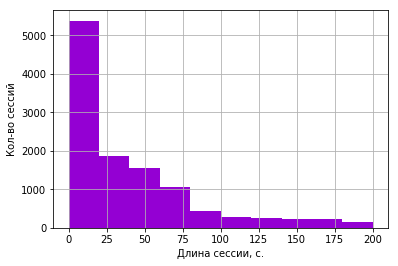

In [13]:
fig, ax = plt.subplots()
train_data_10users['session_timespan'][train_data_10users['session_timespan'] <= 200].hist(color='darkviolet', ax=ax)
ax.set_xlabel(u'Длина сессии, с.')
ax.set_ylabel(u'Кол-во сессий')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

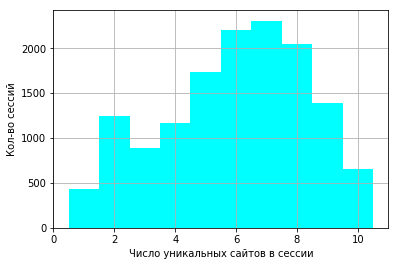

In [14]:
fig, ax = plt.subplots()
train_data_10users['#unique_sites'].hist(bins=np.linspace(1-0.5, 10+0.5, 10+1), color='aqua', ax=ax)
ax.set_xlabel(u'Число уникальных сайтов в сессии')
ax.set_ylabel(u'Кол-во сессий')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

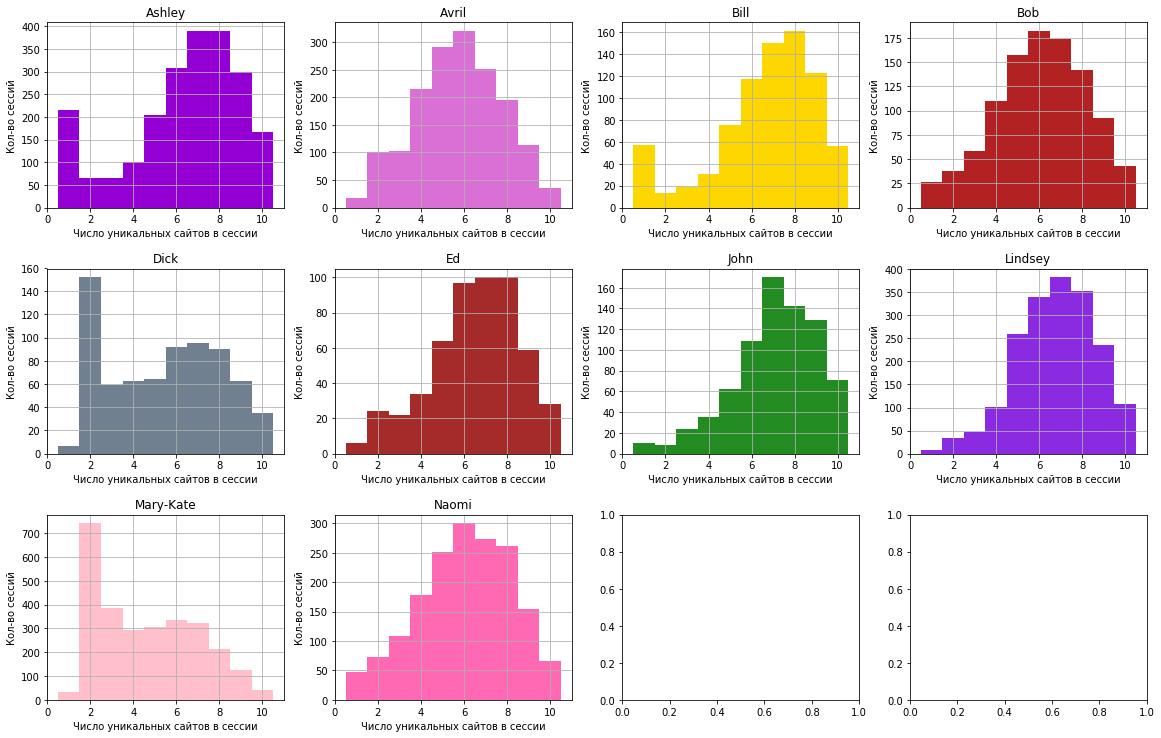

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(w_pad=2, h_pad=4)

# как вариант, можно и по-другому
for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')): 
    ax = axes[idx // 4, idx % 4]
    sub_df['#unique_sites'].hist(bins=np.linspace(1-0.5, 10+0.5, 10+1), color=color_dic[user], ax=ax)
    ax.set_title(user)
    ax.set_xlabel(u'Число уникальных сайтов в сессии')
    ax.set_ylabel(u'Кол-во сессий')

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

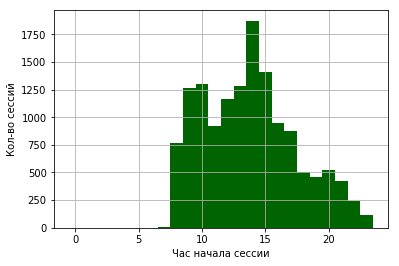

In [16]:
fig, ax = plt.subplots()
train_data_10users['start_hour'].hist(bins=np.linspace(0-0.5, 23+0.5, 24+1), color='darkgreen', ax=ax)
ax.set_xlabel(u'Час начала сессии')
ax.set_ylabel(u'Кол-во сессий')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

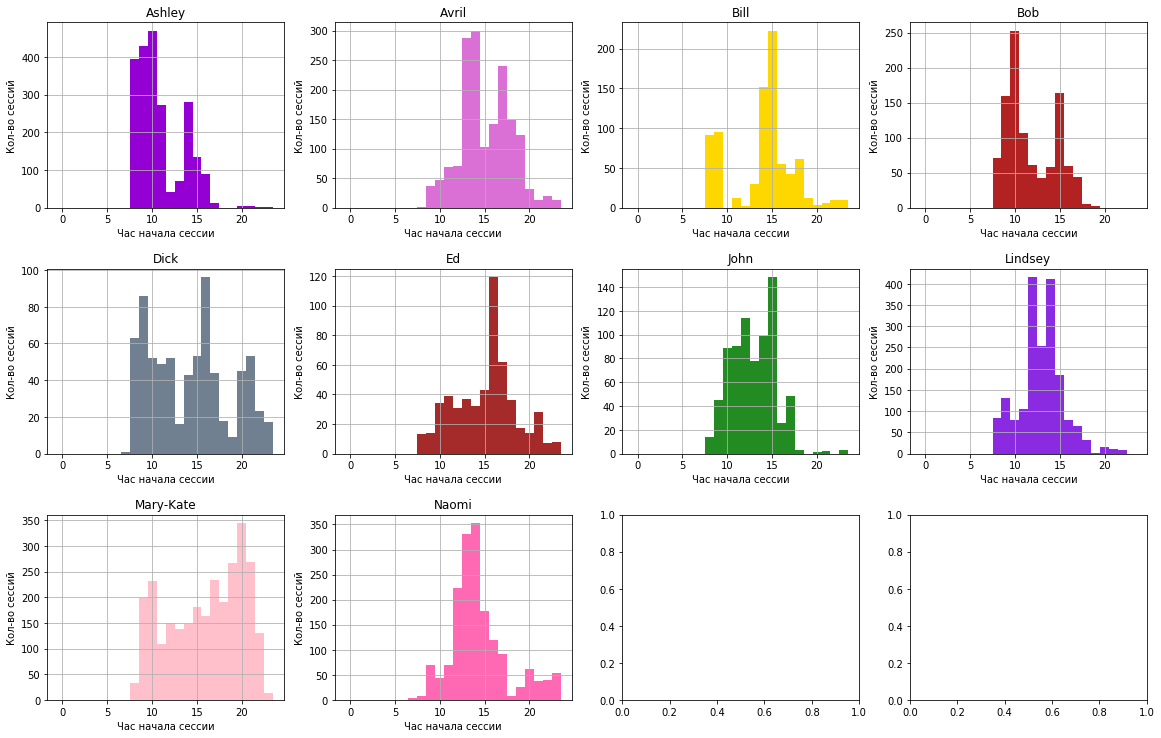

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(w_pad=2, h_pad=4)

# как вариант, можно и по-другому
for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')): 
    ax = axes[idx // 4, idx % 4]
    sub_df['start_hour'].hist(bins=np.linspace(0-0.5, 23+0.5, 24+1), color=color_dic[user], ax=ax)
    ax.set_title(user)
    ax.set_xlabel(u'Час начала сессии')
    ax.set_ylabel(u'Кол-во сессий')

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

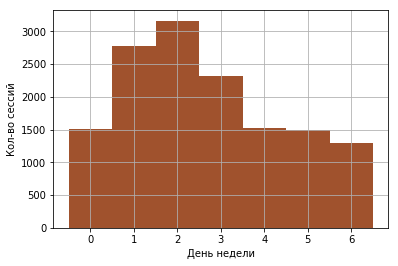

In [18]:
fig, ax = plt.subplots()
train_data_10users['day_of_week'].hist(bins=np.linspace(0-0.5, 6+0.5, 7+1), color='sienna', ax=ax)
ax.set_xlabel(u'День недели')
ax.set_ylabel(u'Кол-во сессий')
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

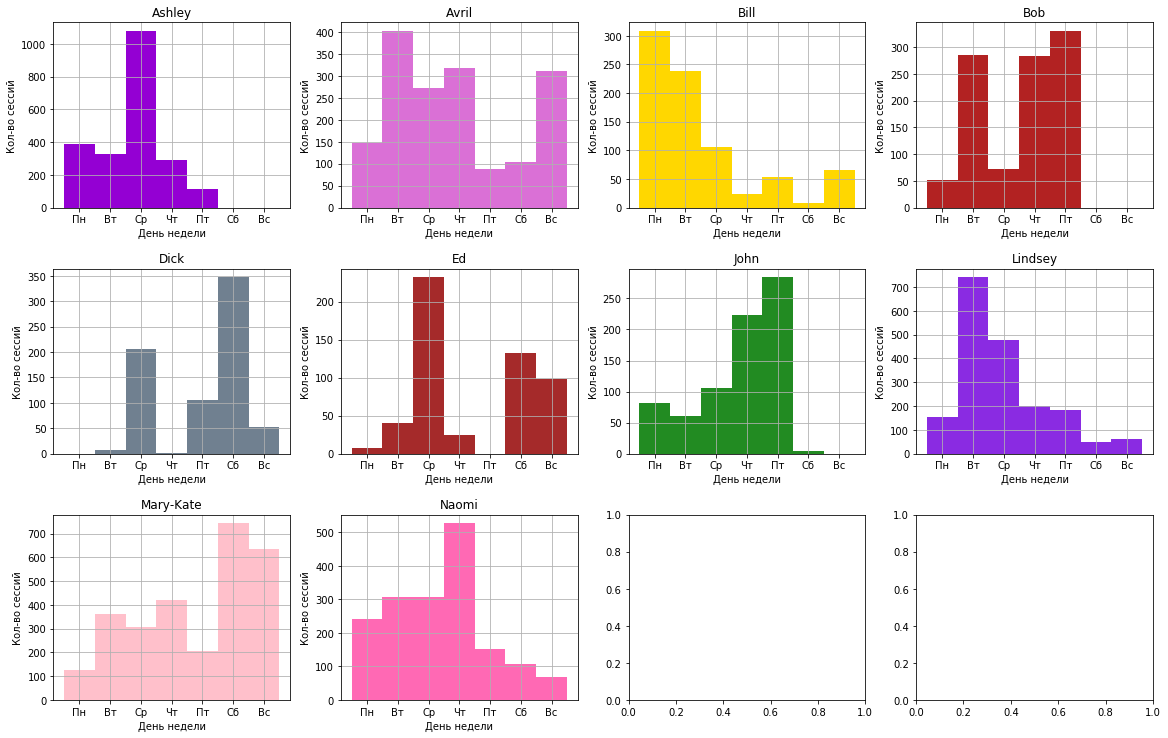

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(w_pad=2, h_pad=4)

# как вариант, можно и по-другому
for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')): 
    ax = axes[idx // 4, idx % 4]
    sub_df['day_of_week'].hist(bins=np.linspace(0-0.5, 6+0.5, 7+1), color=color_dic[user], ax=ax)
    ax.set_xticks(range(6+1))
    ax.set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
    ax.set_title(user)
    ax.set_xlabel(u'День недели')
    ax.set_ylabel(u'Кол-во сессий')

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

*Ashley и Bob наверняка выходят в интернет с рабочего места - в выходные сессии отсутствуют. Возможно, к ним же следует отнести и John - несколько субботних сессий не меняют общей картины. Кроме того, у Bob и John активность повышается к концу рабочей недели. Dick и Ed тоже имеют дни с околонулевой активностью, которые тоже наверняка связаны с занятостью. У Mary-Kate активность в выходные высока. Наверняка она пользуется интернетом из дома. У остальных пользователей активность менее характерная, хотя и со своими особенностями.*

*Час начала сессий у многих пользователей имеет всплески до и после 12-13 часов дня. Спад между ними можно связать с перерывом на обед. Это Ashley, Bob, Bill. У Avril картина похожая, но активность понижается в районе 15-16 часов. У Dick еще один всплеск активности происходит в районе 20-21 часов. Возможно, он пользуется мобильным интернетом и делает перерывы в обеденное время и по пути домой. У Mary-Kate всплеск активности в начале дня, в районе 9-10 часов, но затем активность плавно повышается, достигая пика в 20 часов. Это похоже на активность человека, который проводит день дома за компьютером. Ed и Naomi имеют заметную активность после 20 часов, причем у Naomi имеется спад активности в районе 18 часов. Это похоже на активность человека, который пользуется мобильным интернетом и делает перерыв по пути домой.*

*Количество посещенных сайтов у всех пользователей напоминает биномиальное распределение, с пиком в районе 6-8 сайтов. Это похоже на обычный серфинг, например, на поиск в google. Однако пользователи Ashley, Bill, Dick и Mary-Kate имеют также всплеск в районе 1-2 сайтов, что означает, что они любят иногда посидеть на определенных сайтах. Как видно ниже из частот посещений популярных сайтов, это могут быть google, youtube, facebook и т.д. Менее выраженные, но тем не менее заметные повышения в районе 1-2 сайтов есть также у пользователей Avril, Bob, Ed и John.*

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей.**

In [20]:
with open(os.path.join(PATH_TO_INTERIM_DATA, 
                       'site_freq_10users.pkl'), 'rb') as site_freq_10users_pkl:
    site_freq_10users = pickle.load(site_freq_10users_pkl)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [21]:
top10_sites = [el[0] for el in sorted(site_freq_10users.items(), key=lambda x: -x[1][1])[:10]]
top10_freqs = [site_freq_10users[site][1] for site in top10_sites]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

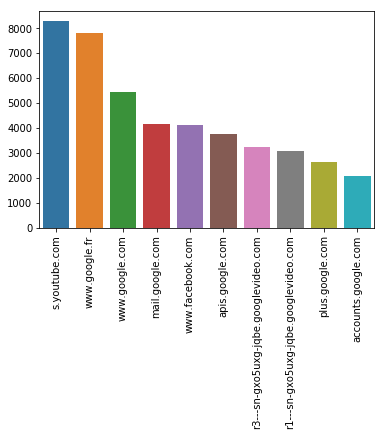

In [22]:
sns.barplot(top10_sites, top10_freqs)
plt.xticks(rotation=90)
plt.show()

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [23]:
np.median(train_data_10users['session_timespan'])

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [24]:
np.median(train_data_10users['day_of_week'])

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [25]:
np.median(train_data_150users['start_hour'])

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [26]:
np.median(train_data_150users['#unique_sites'])

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

#### Цепи Маркова

*Кодирование сессии в виде мешка слов не учитывает порядок посещаемых сайтов. В этой задаче порядок - это наверняка существенная информация: пользователи как правило переходят по ссылкам с одного сайта на другой, а значит порядок посещения сайтов будет неслучайным - нельзя перейти с одного сайта на другой, если нет соответствующей ссылки.*

*Можно по-разному попробовать учесть порядок сайтов. Первое, что приходит в голову - посчитать количество не только сайтов в сессии, но и пар сайтов, идущих друг за другом. Таких признаков будет очень много, и это может значительно увеличить время обучения модели. Попрообуем другой подход.*

*Посещение пользователем сайтов можно представить в виде [цепи Маркова](https://ru.wikipedia.org/wiki/Цепь_Маркова). Будем считать, что пользователь, находясь на сайте X, может перейти на сайт Y (возможно, совпадающий с X) с определенной, фиксированной вероятностью, зависящей только от X и Y. Тогда, зная все такие попарные вероятности, можно оценить вероятность пронаблюдать данную сессию - одни сессии будут более вероятными с точки зрения выбранного пользователя, а другие менее вероятными. Такие вероятности сессий для каждого пользователя и будут новыми признаками (поскольку они будут очень маленькими, сразу возьмем логарифм).*

*В принципе, из одних этих вероятностей сессий можно сделать классификатор. Для выбранной сессии тот пользователь, у которого вероятность пронаблюдать эту сессию будет максимальной, и будет наиболее вероятным "автором" этой сессии. Тем не менее, стоит попробовать передать эти вероятности в качестве признаков в какой-нибудь другой классификатор. Так мы хотя бы сможем учесть и другие построенные признаки при классификации.*

*Нетрудно сообразить, как обучить модель и делать предсказания. По обучающей выборке посчитаем частоты пар сайтов и в соответствии с ними рассчитаем вероятности перехода с одного сайта на другой, нормализовав их (суммарная вероятность перехода с сайта X куда-либо еще должна равняться 1). Затем при предсказании вероятность пронаблюдать первый сайт в сессии умножим на вероятности последовательных пар сайтов.*

*Есть лишь одна тонкость. При предсказании могут попасться сайты, которых не было в обучающей выборке. Строго говоря, вероятность пронаблюдать такую сессию равна нулю, и это справедливо, но не очень продуктивно. Так мы теряем остальную информацию - если, скажем, 9 из 10 сайтов известны и порядок их посещения явно указывает на какого-то пользователя, глупо было бы потерять эту информацию, приравняв вероятность сессии с эточки зрения этого пользователя к нулю. Нужен какой-то способ присваивать вероятности так, чтобы частичная информация тоже эффективно учитывалась.*

*Мне пришла в голову такая идея - давайте все незнакомые сайты кодировать как один сайт, "неизвестный". Тем самым состояниями цепи Маркова у нас будут известные сайты (из обучающей выборки) плюс еще один, неизвестный. Вероятность перехода с неизвестного сайта на любой другой (в том числе опять на неизвестный) выберем одинаковой: 1/(количество известных сайтов + 1). Мы не знаем, как пользователь переходит с неизвестного сайта, и равномерное распределение кажется наиболее разумной оценкой.* 

*Вероятность перейти с известного сайта на неизвестный стоит выбрать более хитро. Нам нужно, чтобы она уменьшалась по мере того, как мы узнаем больше информации о пользователе. Скажем, если мы в обучающей выборке пронаблюдали, как пользователь переходит с сайта X куда-либо еще лишь 1 раз, то вероятность перехода с сайта X на неизвестный стоит сделать довольно высокой - мы мало узнали о том, куда переходит пользователь с сайта X, поэтому довольно вероятно, что в дальнейшем он будет переходить с сайта X на сайты, которые нам неизвестны (в обучающей выборке). Если же мы пронаблюдали, как он переходит с сайта X 100 раз, то мы уже довольно много знаем, и стоит оценить вероятность перехода на неизвестный сайт довольно низкой.*

*Руководствуясь этими соображениями, оценим вероятность перехода с сайта X на неизвестный как 1/(количество переходов с сайта X + 1). Единицу в знаменателе нужно прибавить, чтобы суммарная вероятность перехода куда-либо с сайта X равнялась 1.*

*Существуют готовые пакеты для построения цепей Маркова с привычным интерфейсом sklearn. Например, [pomegranate](https://pomegranate.readthedocs.io/en/latest/MarkovChain.html). С ними в целом все хорошо, но я не увидел возможности работать с "неизвестным" состоянием так, как описано выше (или как-то еще). Там везде предполагается, что при обучении мы узнаем все состояния цепи, и если при предсказании попадается неизвестное состояние, то совокупная вероятность равна нулю. Лучшее, что представляется возможным в этой ситуации - обучить модель на выборке, а затем вручную добавить в модель новое состояние для неизвестного сайта, задать вероятности перехода в это состояние и из него, как обсуждалось выше, и затем перед предсказанием кодировать неизвестные сайты в сессии этим добавленным состоянием. Но на самом деле обучить модель довольно просто, и если уж все равно придется делать половину работы вручную, то почему бы не сделать ее всю, причем более удобным для себя образом?*

*Так я и поступил. Кроме того, в моей реализации не требуется кодировать неизвестные сайты перед предсказанием - модель делает это сама внутри себя.*

In [27]:
class MarkovChainWithUnknownState():
    def __init__(self):
        self.probs_single = {}
        self.probs = {}
        self.unknown_probs = {}
        self.unknown_prob_single = 0
    
    def fit(self, X):
        #count bigrams in a shape of dict of dicts
        for sequence in X:
            for word1, word2 in zip(sequence[:-1], sequence[1:]):
                if word1 not in self.probs:
                    self.probs[word1] = {}
                if word2 not in self.probs[word1]:
                    self.probs[word1][word2] = 1
                else:
                    self.probs[word1][word2] += 1
        #for each word1
        #normalize counts into probabilities so that the probability of an unknown word2 were included and equal to 1/(total+1)
        totals = {word1: sum(self.probs[word1].values()) for word1 in self.probs}
        for word1 in self.probs:
            for word2 in self.probs[word1]:
                self.probs[word1][word2] /= (totals[word1] + 1)
            self.unknown_probs[word1] = 1 / (totals[word1] + 1)
        #set normalized probs_single and unknown_prob_single - probabilities to observe a single state
        for word1 in totals:
            self.probs_single[word1] = totals[word1] / (sum(totals.values()) + sum(self.unknown_probs.values()))
        self.unknown_prob_single = sum(self.unknown_probs.values()) / (sum(totals.values()) + sum(self.unknown_probs.values()))
    
    def predict_proba(self, X):
        result = []
        for sequence in X:
            subresult = 0
            #probability of the first word
            if sequence[0] not in self.probs_single:
                subresult += np.log(self.unknown_prob_single)
            else:
                subresult += np.log(self.probs_single[sequence[0]])
            #transition probabilities
            for word1, word2 in zip(sequence[:-1], sequence[1:]):
                if word1 not in self.probs:
                    #if word1 is unknown, probability word1 -> word2 is uniformly distributed 
                    #over known words (only word1 are counted) + one unknown word
                    subresult += np.log(1 / (len(self.probs) + 1))
                elif word2 not in self.probs[word1]:
                    #if word2 is unknown, get probability from self.unknown_probs
                    subresult += np.log(self.unknown_probs[word1])
                else:
                    subresult += np.log(self.probs[word1][word2])
            result.append(subresult)
        return result

*Построенные признаки:*
* `year` - год начала сессии
* `month` - месяц начала сессии
* `day` - день начала сессии
* `time_of_day` - время суток, 1-4 (утро/день/вечер/ночь)
* `weekend` - индикатор выходных
* `max_delay` - наибольшее время перехода с одного сайта на следующий
* `avg_delay` - среднее время перехода с одного сайта на следующий
* `max_time` - наибольшее суммарное время, проведенное на одном сайте
* `avg_time` - среднее суммарное время, проведенное на одном сайте
* `#popular_sites` - количество различных популярных сайтов в сессии (топ-30)
* `%popular_sites` - доля различных популярных сайтов в сессии
* `time_popular_sites` - суммарное время, проведенное на популярных сайтах
* `%time_popular_sites` - доля времени, проведенного на популярных сайтах
* `popular_site{i}` - индикаторы посещения популярных сайтов (i=1..30)
* `#facebook` - количество посещений facebook
* `mc{id}` - логарифм вероятности пронаблюдать данную сессию с точки зрения пользователя c идентификатором id (цепь Маркова, см. выше)

In [28]:
def count_popular_sites(sites_df, popular_sites_indicators):
    result = []
    for sites_row, popular_sites_mask in zip(sites_df.values, popular_sites_indicators):
        popular_sites = sites_row[popular_sites_mask]
        result.append( len(np.unique(popular_sites)) )
    return result

def compute_time_on_popular_sites(time_diffs_df, popular_sites_indicators):
    result = []
    for time_diffs_row, popular_sites_mask in zip(time_diffs_df.values, popular_sites_indicators):
        popular_site_times = time_diffs_row[popular_sites_mask[:-1]] #we don't have a time diff for the last site
        popular_site_times = popular_site_times[~np.isnan(popular_site_times)]
        result.append( int(np.sum(popular_site_times)) )
    return result

def compute_site_times(sites_df, time_diffs_df):
    result = []
    for sites_row, times_row in zip(sites_df.values[:, :-1], time_diffs_df.values): #we don't have a time diff for the last site
        subresult = {}
        for site, time in zip(sites_row, times_row):
            if not np.isnan(time):
                if site not in subresult:
                    subresult[site] = time
                else:
                    subresult[site] += time
        result.append(subresult)
    return result

def compute_max_site_time(site_times):
    return [int(np.max(session_site_times.values())) if len(session_site_times.values()) != 0 else 0 
            for session_site_times in site_times]

def compute_avg_site_time(site_times):
    return [np.mean(session_site_times.values()) if len(session_site_times.values()) != 0 else 0 
            for session_site_times in site_times]

def max_with_default(row, default=0):
    row_ne = row[~np.isnan(row)]
    if len(row_ne) == 0:
        return default
    else:
        return int(np.max(row_ne))

def avg_with_default(row, default=0):
    row_ne = row[~np.isnan(row)]
    if len(row_ne) == 0:
        return default
    else:
        return np.mean(row_ne)

def add_features_new(sessions_df_base, session_times_df, user_site_IDs, verbose=False):
    if verbose: print('Adding features:')
    sessions_df = sessions_df_base.copy()
    #old features
    site_columns = [col for col in sessions_df.columns if col.startswith('site')]
    
    if verbose: print('session_timespan')
    sessions_df['session_timespan'] = session_times_df.apply(get_session_timespan, raw=True, axis=1)
    
    if verbose: print('#unique_sites')
    sessions_df['#unique_sites'] = sessions_df[site_columns].apply(count_unique_sites, raw=True, axis=1)
    
    if verbose: print('start_hour')
    sessions_df['start_hour'] = session_times_df['site1'].dt.hour
    
    if verbose: print('day_of_week')
    sessions_df['day_of_week'] = session_times_df['site1'].dt.dayofweek
    
    #new features
    time_diffs_df = pd.DataFrame(index=session_times_df.index)
    for i in range(1, 9+1):
        time_diffs_df['diff{}'.format(i)] = (session_times_df['site{}'.format(i+1)] - 
                                             session_times_df['site{}'.format(i)]) / np.timedelta64(1, 's')
    popular_sites = np.arange(1, 30+1)
    popular_sites_indicators = np.isin(sessions_df[site_columns].values, popular_sites)
    site_times = compute_site_times(sessions_df[site_columns], time_diffs_df)
        
    if verbose: print('year')
    sessions_df['year'] = session_times_df['site1'].dt.year
    
    if verbose: print('month')
    sessions_df['month'] = session_times_df['site1'].dt.month
    
    if verbose: print('day')
    sessions_df['day'] = session_times_df['site1'].dt.day
    
    if verbose: print('time_of_day')
    sessions_df['time_of_day'] = np.mod(sessions_df['start_hour'] + 2, 24) // 6
    
    if verbose: print('weekend')
    sessions_df['weekend'] = (sessions_df['day_of_week'] >= 5).astype(int)
    
    if verbose: print('max_delay')
    sessions_df['max_delay'] = time_diffs_df.apply(lambda row: max_with_default(row, 0), raw=True, axis=1)
    
    if verbose: print('avg_delay')
    sessions_df['avg_delay'] = time_diffs_df.apply(lambda row: avg_with_default(row, 0), raw=True, axis=1)
    
    if verbose: print('max_time')
    sessions_df['max_time'] = compute_max_site_time(site_times)
    
    if verbose: print('avg_time')
    sessions_df['avg_time'] = compute_avg_site_time(site_times)
    
    if verbose: print('#popular_sites')
    sessions_df['#popular_sites'] = count_popular_sites(sessions_df[site_columns], popular_sites_indicators)
    
    if verbose: print('%popular_sites')
    sessions_df['%popular_sites'] = sessions_df['#popular_sites'] / sessions_df['#unique_sites']
    
    if verbose: print('time_popular_sites')
    sessions_df['time_popular_sites'] = compute_time_on_popular_sites(time_diffs_df, popular_sites_indicators)
    
    if verbose: print('%time_popular_sites')
    sessions_df['%time_popular_sites'] = sessions_df['time_popular_sites'] / sessions_df['session_timespan']
    sessions_df['%time_popular_sites'] = sessions_df['%time_popular_sites'].fillna(0) #session timespan might be zero
    
    for i in tqdm(range(1, 30+1), 
                  desc='Popular site indicators'):
        sessions_df['popular_site{}'.format(i)] = SparseArray(sessions_df[site_columns].apply(
            lambda row: int(np.isin(popular_sites[i-1], row)), raw=True, axis=1))
    
    if verbose: print('#facebook')
    sessions_df['#facebook'] = sessions_df[site_columns].apply(lambda row: np.sum((row == 5).astype(int)), 
                                                               raw=True, axis=1) # facebook id: 5
    
    for user_ID in tqdm(user_site_IDs, 
                        desc='Markov chain probabilities', disable=not verbose):
        user_mc = MarkovChainWithUnknownState()
        user_mc.fit([user_site_IDs[user_ID]])
        sessions_df['mc{}'.format(user_ID)] = user_mc.predict_proba(sessions_df[site_columns].values)
    
    
    #move user_id column to the end
    user_id = sessions_df['user_id']
    del sessions_df['user_id']
    sessions_df['user_id'] = user_id
    return sessions_df

def feature_engineering(path_to_csv_files, site_freq_path=None, feature_names=None, 
                        session_length=10, window_size=10, verbose=False):
    if site_freq_path is None:
        site_ID_freqs = make_site_ID_freqs(path_to_csv_files, verbose=verbose)
    else:
        with open(site_freq_path, 'rb') as fin:
            site_ID_freqs = pickle.load(fin)
    user_site_IDs, user_visiting_times = make_user_site_IDs_and_visiting_times(path_to_csv_files, site_ID_freqs, 
                                                                               verbose=verbose)
    sessions_df, session_times_df = make_sessions_and_session_times(user_site_IDs, user_visiting_times, 
                                                                    session_length, window_size, verbose=verbose)
    sessions_df = add_features_new(sessions_df, session_times_df, user_site_IDs, verbose=verbose)
    if feature_names is not None:
        sessions_df.columns = feature_names
    return sessions_df

In [29]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_RAW_DATA, '10users'), 
                                           site_freq_path=os.path.join(PATH_TO_INTERIM_DATA, 'site_freq_10users.pkl'), 
                                           session_length=10, verbose=True)

Constructing sessions: 100%|██████████| 10/10 [00:00<00:00, 625.00it/s]


Adding features:
session_timespan
#unique_sites
start_hour
day_of_week
year
month
day
time_of_day
weekend
max_delay
avg_delay
max_time
avg_time
#popular_sites
%popular_sites
time_popular_sites
%time_popular_sites


Popular site indicators: 100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


#facebook


Markov chain probabilities: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Wall time: 17.7 s


In [30]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_RAW_DATA, '150users'), 
                                            site_freq_path=os.path.join(PATH_TO_INTERIM_DATA, 'site_freq_150users.pkl'), 
                                            session_length=10, verbose=True)

Constructing sessions: 100%|██████████| 150/150 [00:00<00:00, 385.60it/s]


Adding features:
session_timespan
#unique_sites
start_hour
day_of_week
year
month
day
time_of_day
weekend
max_delay
avg_delay
max_time
avg_time
#popular_sites
%popular_sites
time_popular_sites
%time_popular_sites


Popular site indicators: 100%|██████████| 30/30 [02:06<00:00,  4.23s/it]


#facebook


Markov chain probabilities: 100%|██████████| 150/150 [06:07<00:00,  2.45s/it]


Wall time: 8min 29s


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [31]:
new_features_10users['target'] = new_features_10users['user_id'].map(id_name_dict)

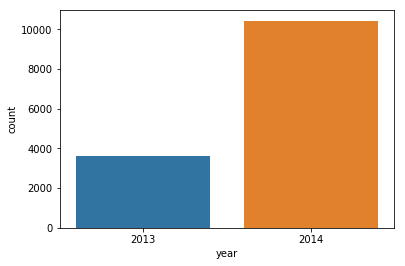

In [32]:
sns.countplot('year', data=new_features_10users)

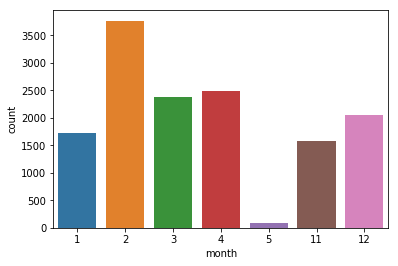

In [33]:
sns.countplot('month', data=new_features_10users)

*Отсутствуют данные с июня по октябрь. Учитывая год, наверняка данные собирались с ноября 2013 по май 2014. Убедимся в этом:*

In [34]:
new_features_10users[['year', 'month']].apply(lambda row: '-'.join(map(str, row)), axis=1).unique()

array(['2013-11', '2013-12', '2014-1', '2014-2', '2014-3', '2014-4',
       '2014-5'], dtype=object)

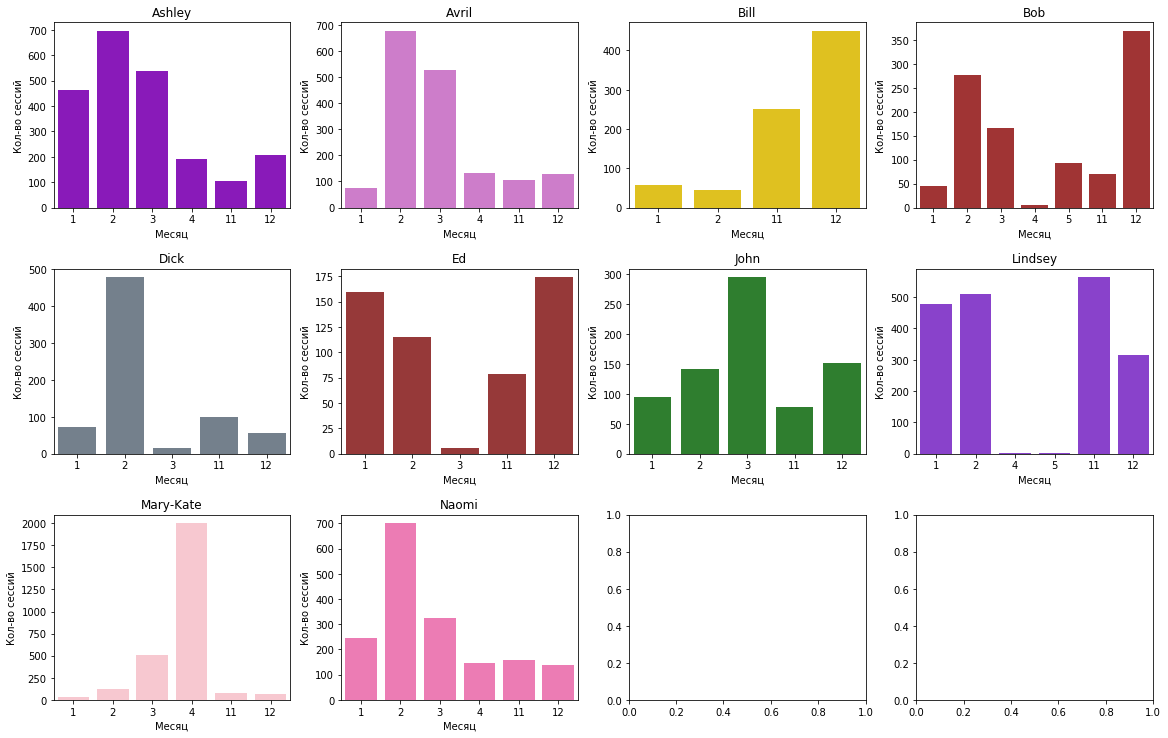

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(w_pad=2, h_pad=4)

for idx, (user, sub_df) in enumerate(new_features_10users.groupby('target')): 
    ax = axes[idx // 4, idx % 4]
    sns.countplot('month', data=sub_df, color=color_dic[user], ax=ax)
    ax.set_title(user)
    ax.set_xlabel(u'Месяц')
    ax.set_ylabel(u'Кол-во сессий')

*Возможно, зависимость количества посещений от месяца/года и является важной для определения пользователей, но данных явно мало, поэтому не стоит использовать этот признак. Что мы будем делать, если в реальной задаче придут новые данные, скажем, за июнь?*

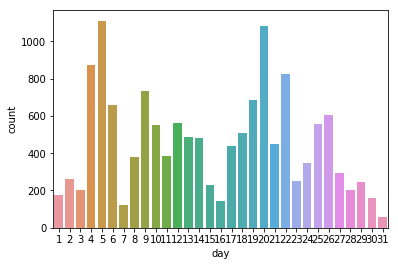

In [36]:
sns.countplot('day', data=new_features_10users)

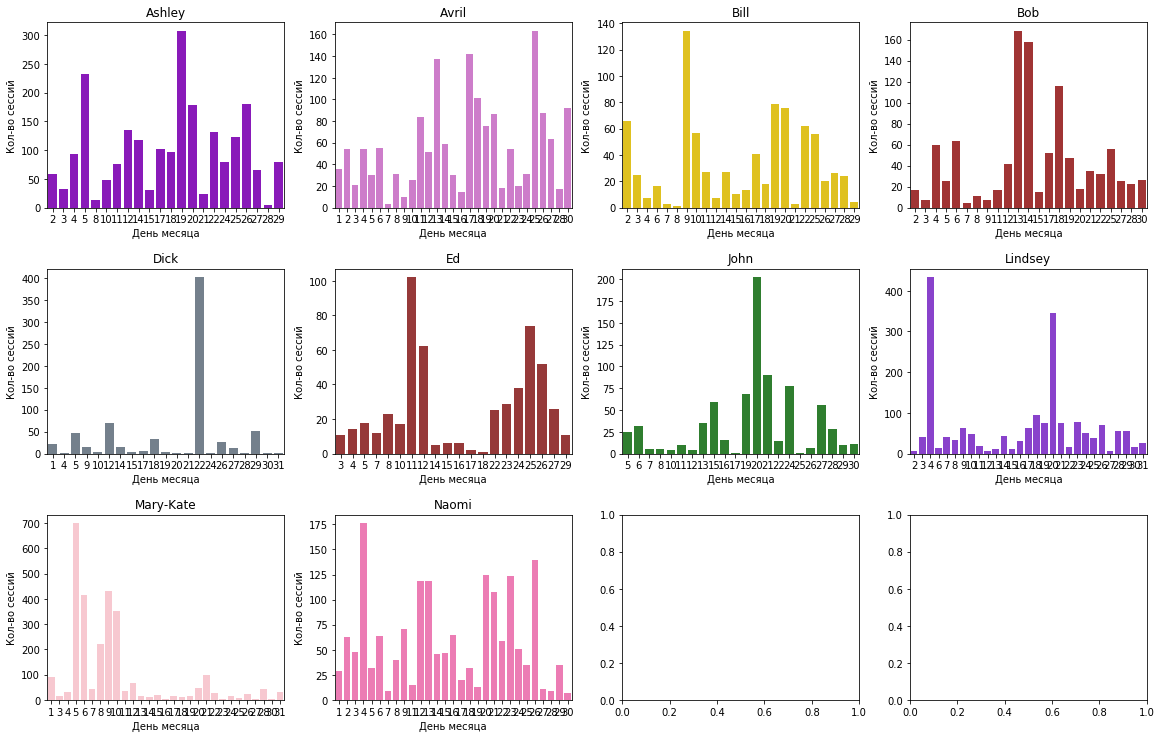

In [37]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(w_pad=2, h_pad=4)

for idx, (user, sub_df) in enumerate(new_features_10users.groupby('target')): 
    ax = axes[idx // 4, idx % 4]
    sns.countplot('day', data=sub_df, color=color_dic[user], ax=ax)
    ax.set_title(user)
    ax.set_xlabel(u'День месяца')
    ax.set_ylabel(u'Кол-во сессий')

*Весьма странные распределения, из которых сложно делать какие-то выводы. Можно отметить, например, аномальную активность пользователя Dick 22 числа. Стоит ли связывать 22е число начала сессии с ним? Пожалуй, нет. Скорее всего, это была какая-то разовая активность, которая вряд ли повторится в будущем. Проверим это:*

In [38]:
new_features_10users[(new_features_10users['target'] == 'Dick') & 
                     (new_features_10users['day'] == 22)][['year', 'month']].apply(
    lambda row: '-'.join(map(str, row)), axis=1).value_counts()

2014-2     327
2013-11     63
2014-1      11
dtype: int64

*Так и есть, основная масса сессий 22го числа пришлась на 22е февраля 2014го года.*

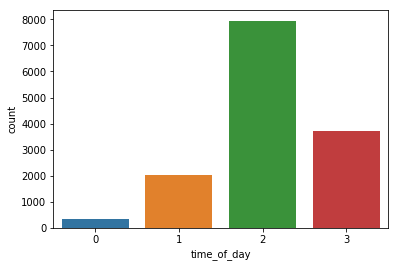

In [39]:
sns.countplot('time_of_day', data=new_features_10users)

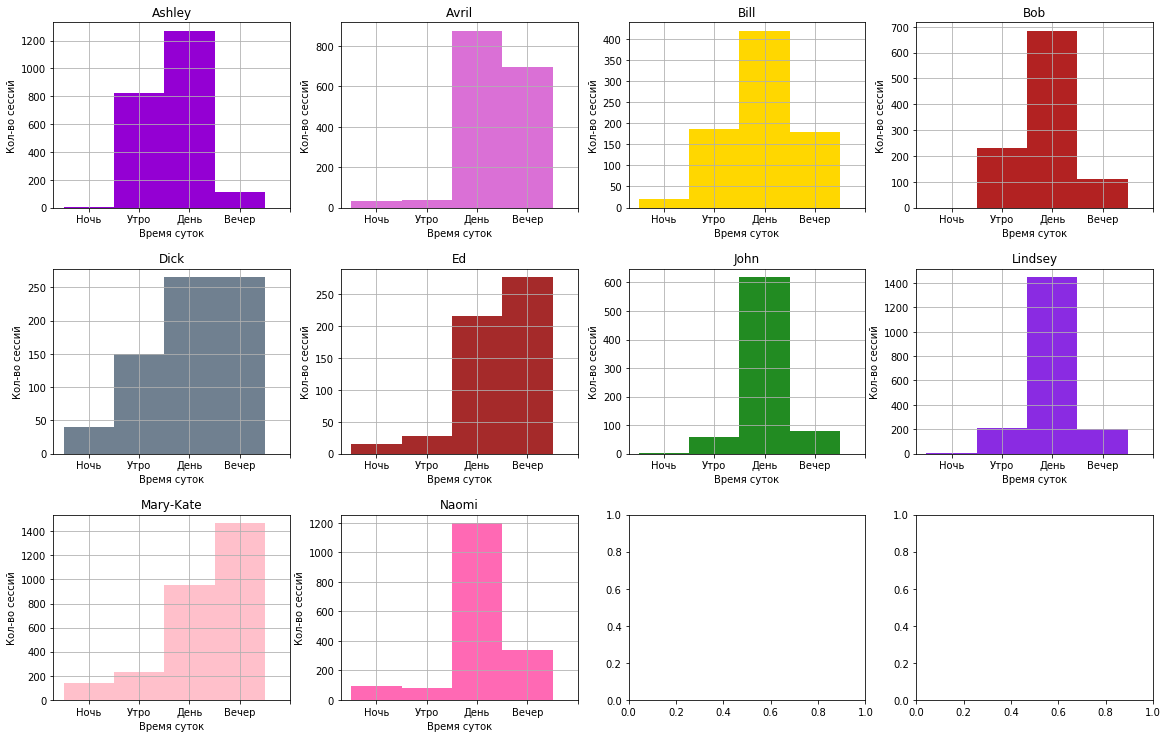

In [40]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(w_pad=2, h_pad=4)

for idx, (user, sub_df) in enumerate(new_features_10users.groupby('target')): 
    ax = axes[idx // 4, idx % 4]
    sub_df['time_of_day'].hist(bins=np.linspace(0-0.5, 3+0.5, 4+1), color=color_dic[user], ax=ax)
    ax.set_xticks(range(4+1))
    ax.set_xticklabels([u'Ночь', u'Утро', u'День', u'Вечер'])
    ax.set_title(user)
    ax.set_xlabel(u'Время суток')
    ax.set_ylabel(u'Кол-во сессий')

*Ту же самую информацию мы уже проанализировали, только более детально (час начала сессии, start_hour). Тем не менее, это тоже полезный признак.*

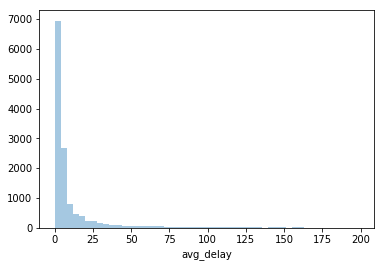

In [41]:
sns.distplot(new_features_10users['avg_delay'][new_features_10users['avg_delay'] < 200], kde=False, norm_hist=False)

*Очень напоминает распределение Пуассона.*

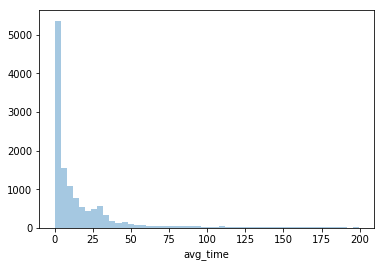

In [42]:
sns.distplot(new_features_10users['avg_time'][new_features_10users['avg_time'] < 200], kde=False, norm_hist=False)

*Здесь имеется небольшой всплеск в районе 25-30 секунд. При анализе признака `session_timespan` будет понятно, с чем он связан.*

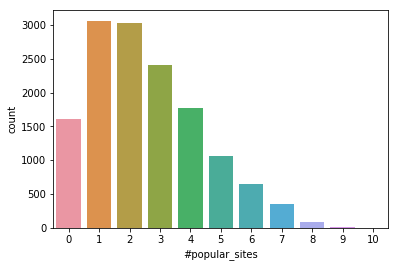

In [43]:
sns.countplot('#popular_sites', data=new_features_10users)

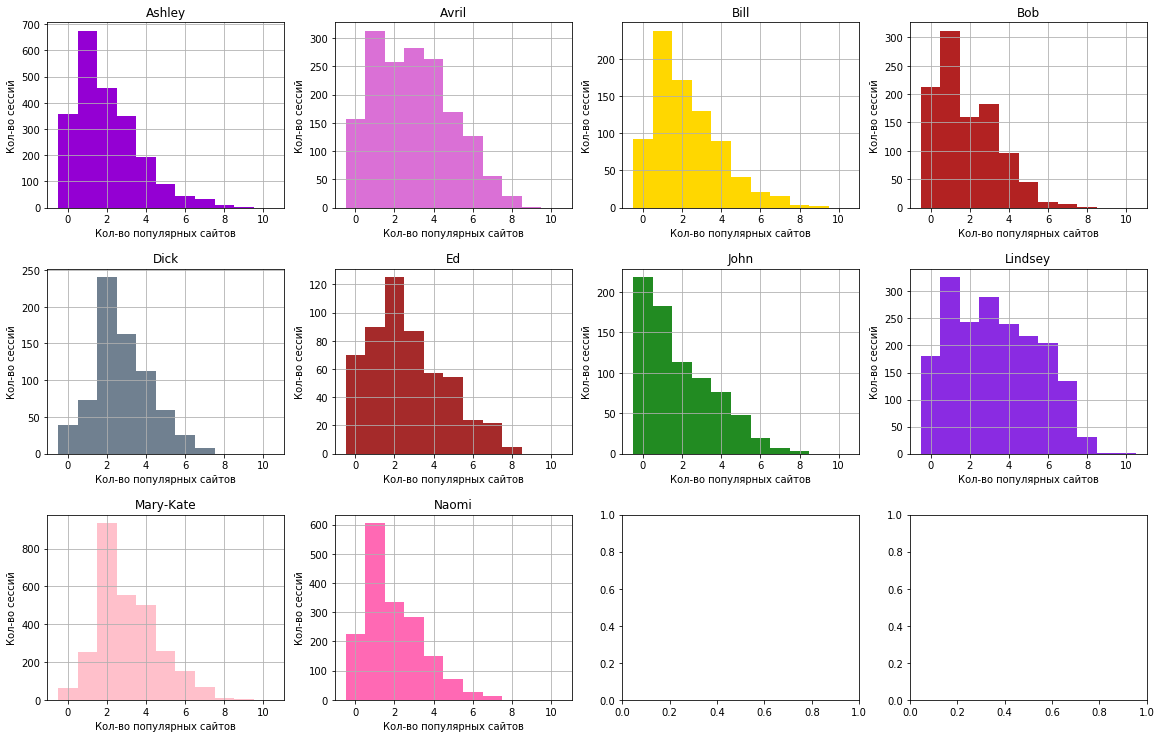

In [44]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(w_pad=2, h_pad=4)

for idx, (user, sub_df) in enumerate(new_features_10users.groupby('target')): 
    ax = axes[idx // 4, idx % 4]
    sub_df['#popular_sites'].hist(bins=np.linspace(0-0.5, 10+0.5, 11+1), color=color_dic[user], ax=ax)
    ax.set_title(user)
    ax.set_xlabel(u'Кол-во популярных сайтов')
    ax.set_ylabel(u'Кол-во сессий')

*У разных пользователей разное характерное количество популярных сайтов. John чаще всего не посещает их вовсе, а Mary-Kate редко на них не заходит. Но в целом все пользователи в основном посещают не более 2-4 популярных сайтов.*

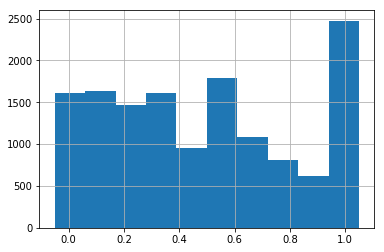

In [45]:
new_features_10users['%popular_sites'].hist(bins=np.linspace(0-0.05, 1+0.05, 10+1))

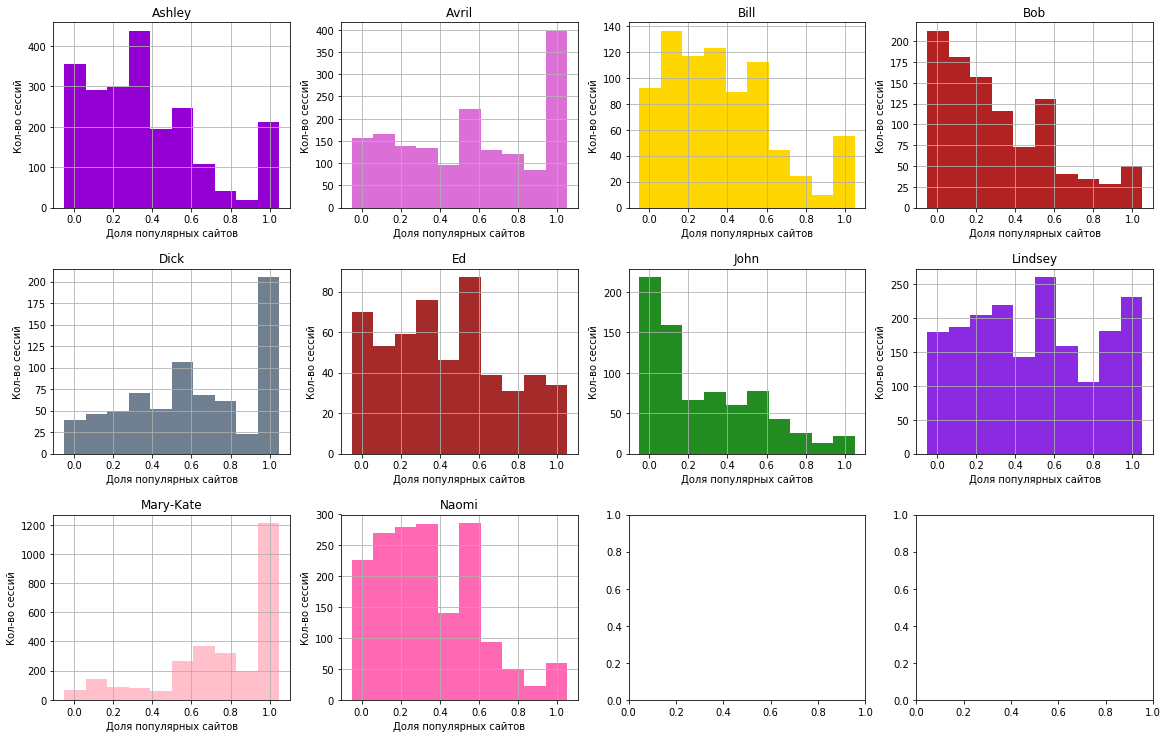

In [46]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(w_pad=2, h_pad=4)

for idx, (user, sub_df) in enumerate(new_features_10users.groupby('target')): 
    ax = axes[idx // 4, idx % 4]
    sub_df['%popular_sites'].hist(bins=np.linspace(0-0.05, 1+0.05, 10+1), color=color_dic[user], ax=ax)
    ax.set_title(user)
    ax.set_xlabel(u'Доля популярных сайтов')
    ax.set_ylabel(u'Кол-во сессий')

*Вот здесь хорошо видно, кто любит посидеть на популярных сайтах (характерные всплески на 100%).*

*Как мы уже выяснили, Bob скорее всего выходит в интернет на рабочем месте. Преобладание 1 популярного сайта в сессии и малое количество популярных сайтов в целом позволяет предположить, что у него этот популярный сайт - google. А вот у Dick, Mary-Kate и Avril это наверняка что-то развлекательное, например youtube или facebook.*

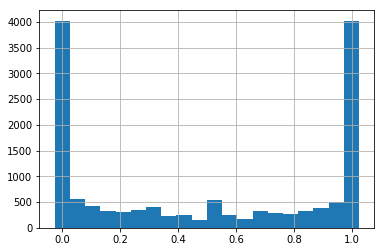

In [47]:
new_features_10users['%time_popular_sites'].hist(bins=np.linspace(0-0.025, 1+0.025, 20+1))

*Примечательно, что в основном все пользователи в течение сессии проводят почти все время либо вне популярных сайтов, либо на них. Видимо, это связано с тем, чем занимается человек в этот момент - какой-то работой или развлечениями.*

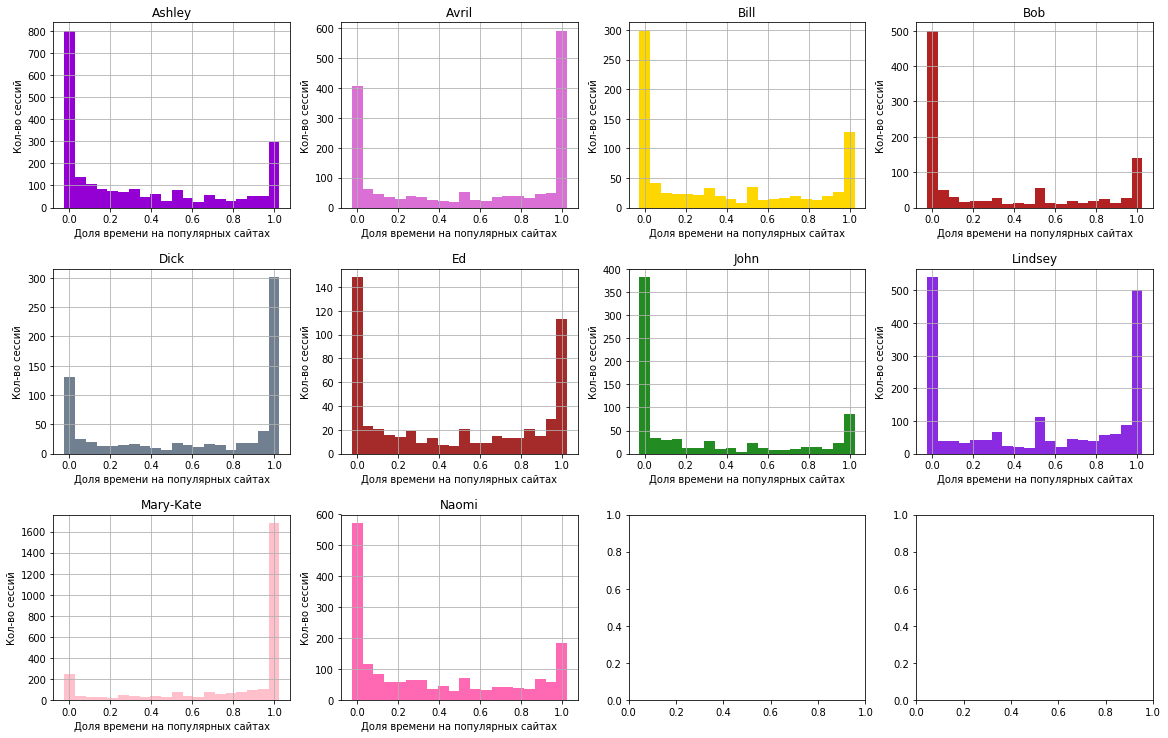

In [48]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(w_pad=2, h_pad=4)

for idx, (user, sub_df) in enumerate(new_features_10users.groupby('target')): 
    ax = axes[idx // 4, idx % 4]
    sub_df['%time_popular_sites'].hist(bins=np.linspace(0-0.025, 1+0.025, 20+1), color=color_dic[user], ax=ax)
    ax.set_title(user)
    ax.set_xlabel(u'Доля времени на популярных сайтах')
    ax.set_ylabel(u'Кол-во сессий')

*Тоже весьма показательно, кто сколько занимается какой-то работой или развлечениями. Bob, John и Naomi явно занимаются преимущественно работой, а Dick и Mary-Kate - развлечениями. Это вполне согласуется с предыдущими выводами.*

*Также это намекает на активность пользователей. Одни люди переходят по сайтам более активно (например, быстро переходя по ссылкам), другие менее активно. Те, кто ведет себя более активно, создадут больше сессий за то же время.*

*Посмотрим на распределение длины сессии session_timespan. Менее активные пользователи будут тратить больше времени в сессии, а более активные - меньше времени.*

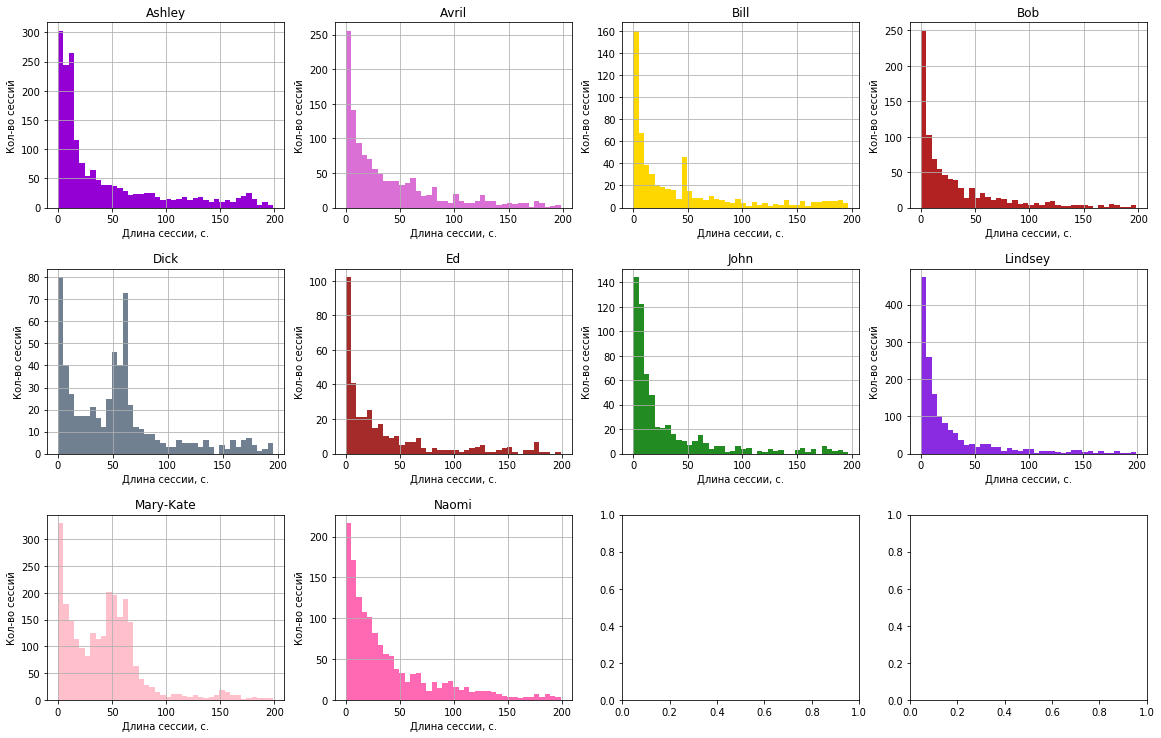

In [49]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(w_pad=2, h_pad=4)

for idx, (user, sub_df) in enumerate(new_features_10users.groupby('target')): 
    ax = axes[idx // 4, idx % 4]
    sub_df['session_timespan'][sub_df['session_timespan'] < 200].hist(bins=40, color=color_dic[user], ax=ax)
    ax.set_title(user)
    ax.set_xlabel(u'Длина сессии, с.')
    ax.set_ylabel(u'Кол-во сессий')

*Примечательны пики в районе 50 секунд у Dick, Mary-Kate и Bill. Поскольку первые двое, предположительно, предпочитают развлекательный контент, видимо, это типичное время просмотра одной страницы какого-либо равзлекательного сайта.*

*Вероятно, стоит разбить длину сессии на 3 диапазона и построить 3 признака-индикатора: длина сессии менее 25 секунд, от 25 до 75 секунд и более 75 секунд. Это поволит лучше отделять Dick и Mary-Kate от остальных на сессиях с длиной в среднем диапазоне. Но имеет ли это смысл для 150 пользователей, да и даст ли это ощутимый выигрыш в качестве? Как правильнее выбрать границы диапазонов? Лучше попробовать эту идею как-нибудь потом.*

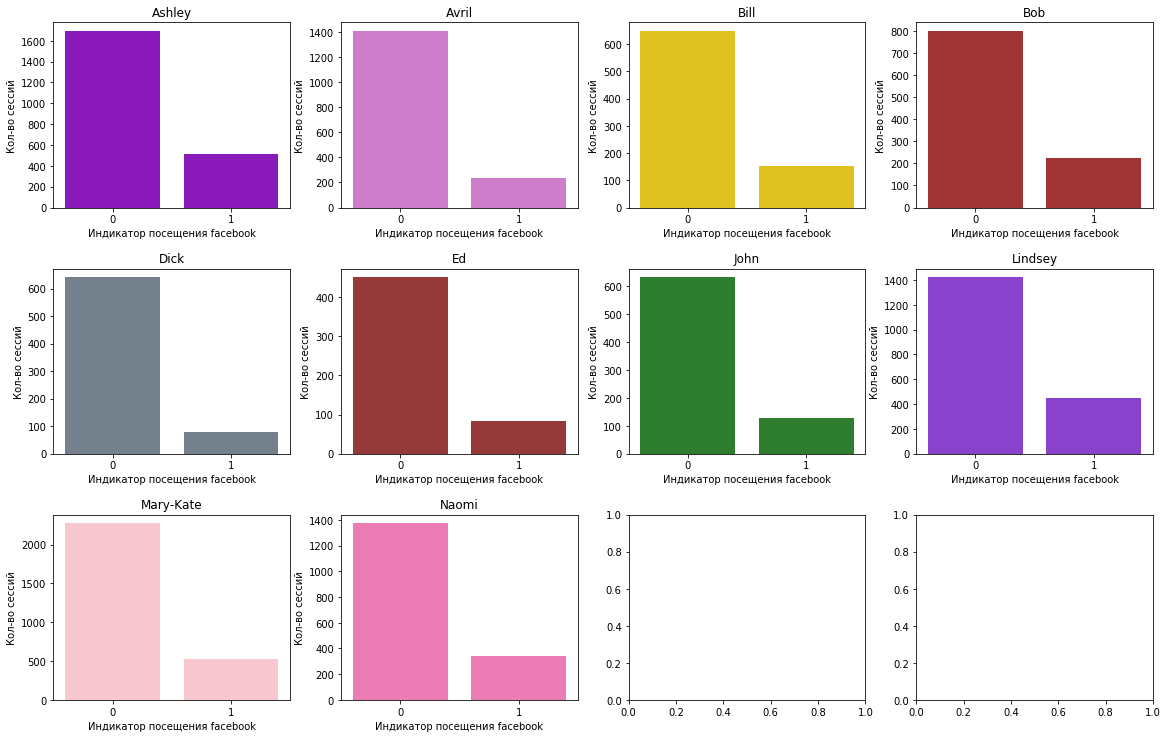

In [50]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(w_pad=2, h_pad=4)

for idx, (user, sub_df) in enumerate(new_features_10users.groupby('target')): 
    ax = axes[idx // 4, idx % 4]
    sns.countplot('popular_site5', data=sub_df, color=color_dic[user], ax=ax)
    ax.set_title(user)
    ax.set_xlabel(u'Индикатор посещения facebook')
    ax.set_ylabel(u'Кол-во сессий')

*Все пользователи посещают facebook примерно одинаково, разница невелика (в смысле доли всех сессий). Видимо, это не очень информативный признак сам по себе. Анализировать все остальные 29 популярных сайтов не будем, предполагая, что там ситуация похожая.*

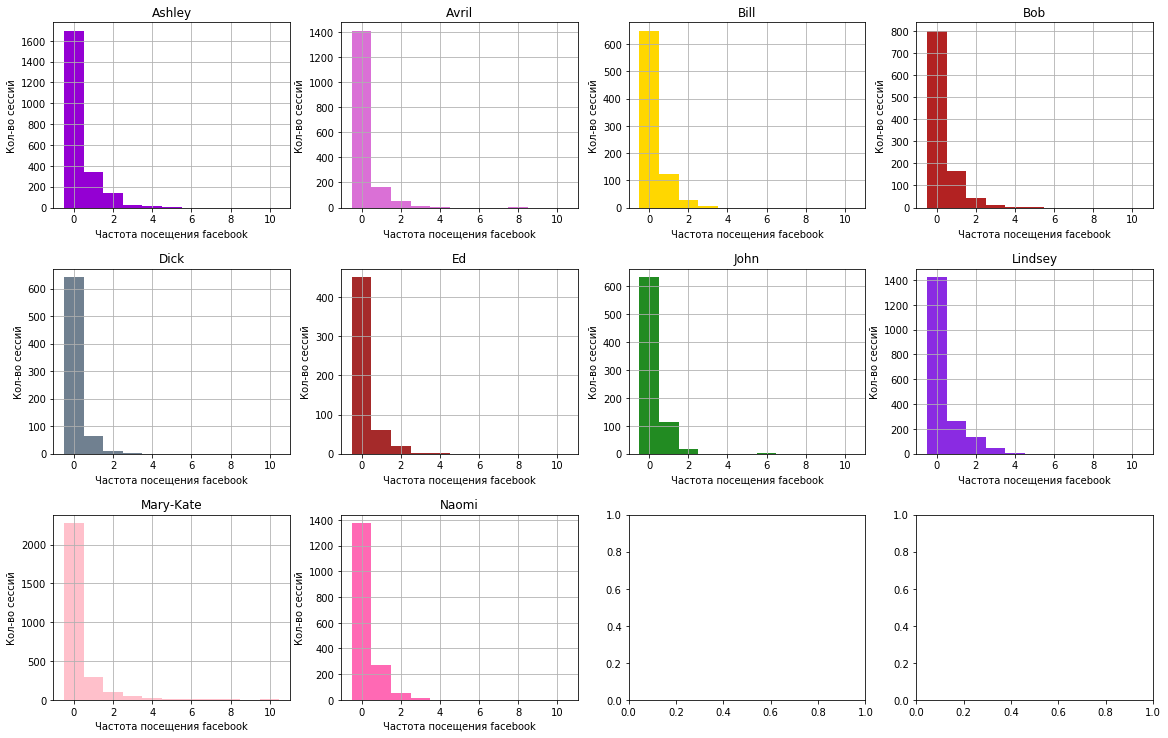

In [51]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(w_pad=2, h_pad=4)

for idx, (user, sub_df) in enumerate(new_features_10users.groupby('target')): 
    ax = axes[idx // 4, idx % 4]
    sub_df['#facebook'].hist(bins=np.linspace(0-0.5, 10+0.5, 11+1), color=color_dic[user], ax=ax)
    ax.set_title(user)
    ax.set_xlabel(u'Частота посещения facebook')
    ax.set_ylabel(u'Кол-во сессий')

*Сессий, в которых facebook не посещают, очень много, и это мешает проанализировать остальные. Удалим их из рассмотрения:*

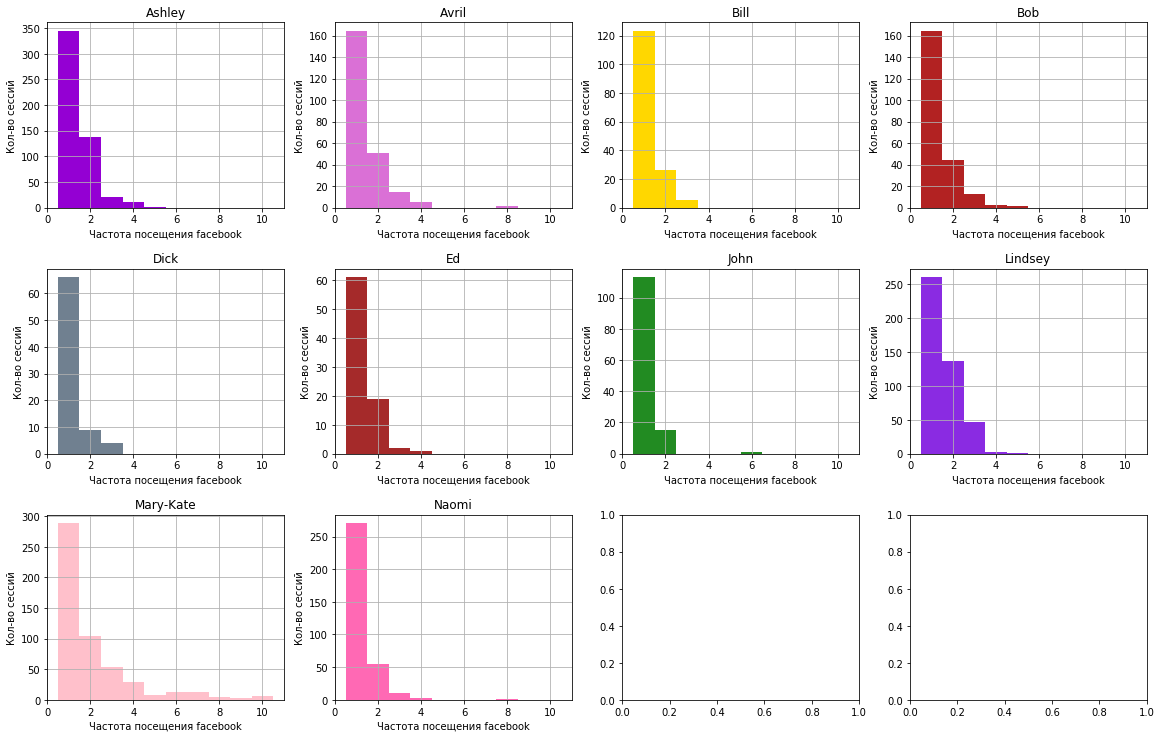

In [52]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(w_pad=2, h_pad=4)

for idx, (user, sub_df) in enumerate(new_features_10users.groupby('target')): 
    ax = axes[idx // 4, idx % 4]
    sub_df['#facebook'][sub_df['#facebook'] > 0].hist(bins=np.linspace(1-0.5, 10+0.5, 10+1), color=color_dic[user], ax=ax)
    ax.set_title(user)
    ax.set_xlabel(u'Частота посещения facebook')
    ax.set_ylabel(u'Кол-во сессий')

*Распределения довольно слабо отличаются. Видимо, это тоже не очень информативный признак. Разве что можно отметить, что Mary-Kate сидит на facebook более активно, чем остальные пользователи (когда вообще туда заходит). Это согласуется с предыдущими выводами.*

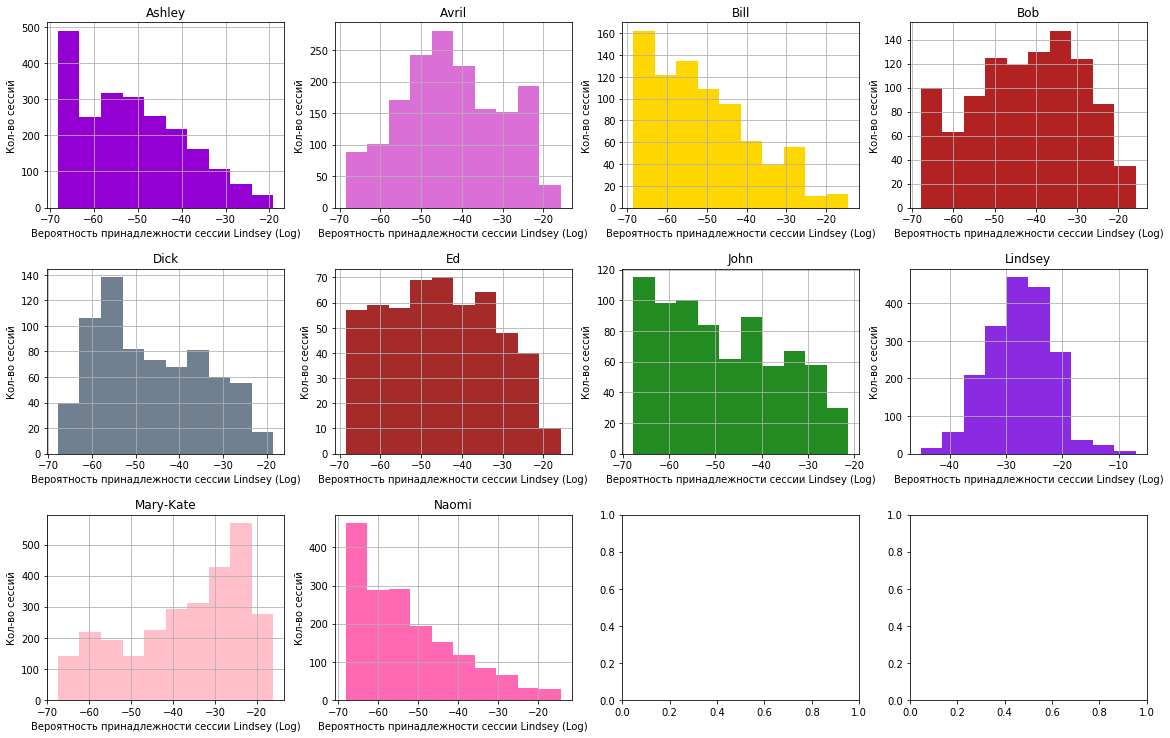

In [53]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.tight_layout(w_pad=2, h_pad=4)

for idx, (user, sub_df) in enumerate(new_features_10users.groupby('target')): 
    ax = axes[idx // 4, idx % 4]
    sub_df['mc207'].hist(color=color_dic[user], ax=ax)
    ax.set_title(user)
    ax.set_xlabel(u'Вероятность принадлежности сессии Lindsey (Log)')
    ax.set_ylabel(u'Кол-во сессий')

*Наконец посмотрим, помогли ли нам цепи Маркова. Специально рассмотрим наиболее непримечательного пользователя - Lindsey.*

*Нетрудно видеть, что сессии самой Lindsey никогда не являются слишком маловероятными (с логарифмом вероятности менее -40), тогда как у всех остальных пользователей есть такие сессии, и немало. Также некоторые сессии являются наиболее типичными для Lindsey (с логарифмом вероятности более -20, что больше, чем для всех сессий всех остальных пользователей). Грубо говоря, можно сказать, что если значение меньше -40, то это точно не сессия Lindsey, а если больше -20 - то это точно ее сессия. В общем, признак полезен.*

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [54]:
mc_features = [col for col in new_features_10users.columns if col.startswith('mc')]
selected_features = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'time_of_day', 'weekend', 'avg_time', 
                     '#popular_sites', '%popular_sites', '%time_popular_sites'] + mc_features
selected_features_10users = new_features_10users[selected_features]
selected_features_150users = new_features_150users[selected_features]

In [55]:
with open(os.path.join(PATH_TO_INTERIM_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_INTERIM_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 